In [2]:
#libaries
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
# read in the data: https://archive.ics.uci.edu/ml/datasets/Poker+Hand 
# suit (1-4)... Heart, Club, Diamond, Spade
# card (1-13)... Ace (low) – King
# hand (0-9) in increasing rank of quality

poker = pd.read_csv('poker-hand-testing.data.txt')

# set column names
poker.columns = ['suit #1','rank #1', 'suit #2', 'rank#2', 'suit#3', 'rank#3', 'suit#4', 'rank#4', 'suit#5', 'rank#5', 'poker hand']
poker.head()


,suit #1,rank #1,suit #2,rank#2,suit#3,rank#3,suit#4,rank#4,suit#5,rank#5,poker hand
0,3,12,3,2,3,11,4,5,2,5,1
1,1,9,4,6,1,4,3,2,3,9,1
2,1,4,3,13,2,13,2,1,3,6,1
3,3,10,2,7,1,2,2,11,4,9,0
4,1,3,4,5,3,4,1,12,4,6,0


In [4]:
poker.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999999 entries, 0 to 999998
Data columns (total 11 columns):
suit #1       999999 non-null int64
rank #1       999999 non-null int64
suit #2       999999 non-null int64
rank#2        999999 non-null int64
suit#3        999999 non-null int64
rank#3        999999 non-null int64
suit#4        999999 non-null int64
rank#4        999999 non-null int64
suit#5        999999 non-null int64
rank#5        999999 non-null int64
poker hand    999999 non-null int64
dtypes: int64(11)
memory usage: 83.9 MB


In [14]:
poker['poker hand'].value_counts()

0    501208
1    422498
2     47622
3     21121
4      3885
5      1996
6      1424
7       230
8        12
9         3
Name: poker hand, dtype: int64

In [15]:
poker.describe()

,suit #1,rank #1,suit #2,rank#2,suit#3,rank#3,suit#4,rank#4,suit#5,rank#5,poker hand
count,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000
mean,2.500495,6.997933,2.499895,7.006091,2.500872,6.998876,2.500394,7.002302,2.499452,6.989476,0.616903
std,1.117767,3.743371,1.118568,3.743478,1.118225,3.741891,1.117246,3.741270,1.118948,3.739893,0.773377
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,2.000000,4.000000,1.000000,4.000000,1.000000,4.000000,2.000000,4.000000,1.000000,4.000000,0.000000
50%,3.000000,7.000000,3.000000,7.000000,3.000000,7.000000,3.000000,7.000000,2.000000,7.000000,0.000000
75%,3.000000,10.000000,4.000000,10.000000,4.000000,10.000000,3.000000,10.000000,4.000000,10.000000,1.000000
max,4.000000,13.000000,4.000000,13.000000,4.000000,13.000000,4.000000,13.000000,4.000000,13.000000,9.000000


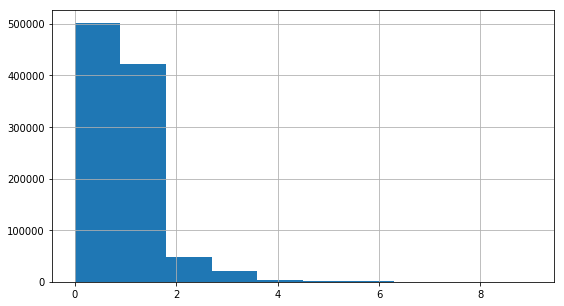

In [40]:
poker['poker hand'].hist(figsize=(9,5))
plt.show()

In [42]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(poker, test_size=0.2, random_state=42)

In [ ]:
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)